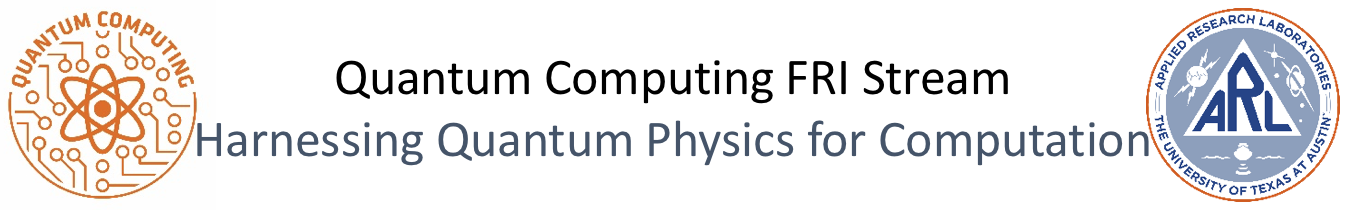

# Oracle Building
## Lesson 6

### Installations and Imports

In [46]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [47]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector

## Today's Objectives

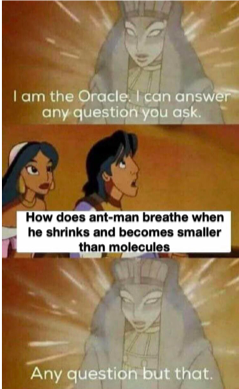

 - Implement Grover's Search Algorithm for the case of multiple solutions
 - Build a quantum circuit for a given CNF Boolean function
 - Convert a Boolean expression from CNF to ESOP form
 - Build a quantum circuit for a given ESOP Boolean function

## General Boolean Search Problem

$\text{Let }f:\{0,\dots ,N-1\}\to\{0,1\}\text{ be a Boolean function.}\quad(N=2^{n})$

$f(x)=1\text{ for }x\in\{a_{1},\dots,a_{M}\}\qquad \color{blue}{\text{Notice the multiple solutions!}}$

$f(x)=0 \text{ for all other }x$



$\text{Any random guess has a success probability of }M/N$

$\text{Can we apply Grover's algorithm?}$


### Grover's Search Algorithm for $M$ Solutions

$1) \text{ Start with an }n\text{-qubit input and 1-qubit output register.}$
$$|0\dots 0\rangle|0\rangle$$

$2) \text{ Apply a NOT and then Hadamard to the output register.}$

$3) \text{ Apply Hadamards to the input register.}$

$4) \text{ Do the following }R\text{ times, where }\color{red}{R=\big\lfloor\pi\sqrt{N/M}/4\big\rfloor}$

$\quad \text{a) Apply the oracle }\mathbf{U}_{f}$

$\quad \text{b) Apply }\mathbf{W}=-\prod_{i=1}^{n}\mathbf{H}_{i}\mathbf{X}_{i} \;\; \mathbf{C}^{\mathbf{Z}}_{n\dots 2 1}\;\prod_{j=1}^{n}\mathbf{X}_{j}\mathbf{H}_{j}\text{ to the input register}$

$5) \text{ Apply a Hadamard and then NOT gate to the output register.}$

$6) \text{ Measure the input register; the result is most likely } \color{red}{\text{one of } a_{1},\dots,a_{M}}.$

### <font color=green>Exercise 1</font>

$\text{The oracle }\mathbf{U}_{f} = \mathbf{C}_{210}\mathbf{C}_{310}\text{ has }M=2\text{ solutions.}$

$\text{Implement Grover's search algorithm on }\mathbf{U}_{f}.$

$\text{What values of }a\text{ do you find?}$

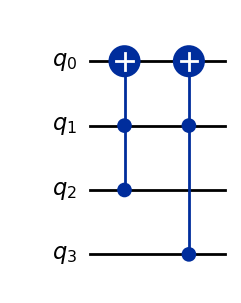

In [48]:
N = 3
U = QuantumCircuit(N+1)

U.ccx(2,1,0)
U.ccx(3,1,0)

U.draw('mpl')


In [49]:
W = QuantumCircuit(N+1)
W.h(W.qubits[1:])
W.x(W.qubits[1:])

W.h(W.qubits[0])
W.mcx(W.qubits[1:], W.qubits[0])
W.h(W.qubits[0])

W.x(W.qubits[1:])
W.h(W.qubits[1:])

1


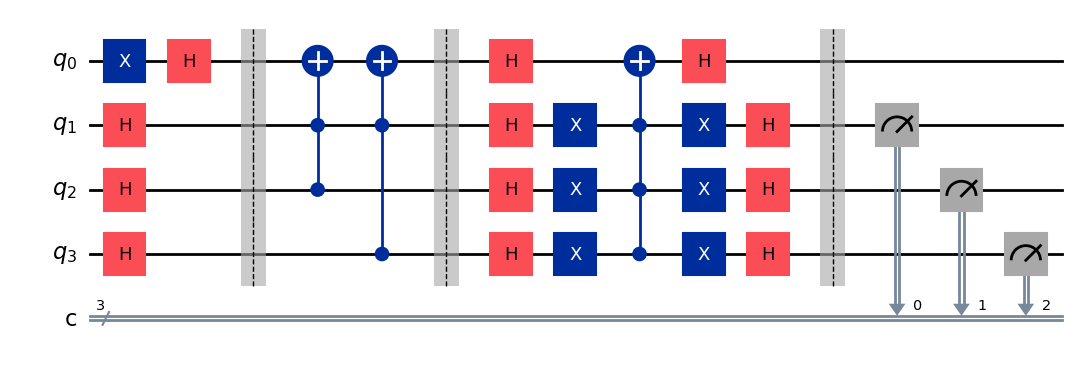

In [50]:
M = 2
qc = QuantumCircuit(N+1,N)
R = int(np.floor(np.pi*np.sqrt(2**N/M)/4))
print(R)
qc.x(qc.qubits[0])
qc.h(qc.qubits)

for i in range(R):
    qc.barrier()
    qc.compose(U,qubits=range(N+1),inplace=True)
    qc.barrier()
    qc.compose(W,qubits=range(N+1),inplace=True)
    qc.barrier()
qc.measure(qc.qubits[1:],qc.clbits)
qc.draw('mpl')


{'110': 63, '001': 65, '100': 74, '011': 317, '111': 66, '101': 317, '000': 57, '010': 65}


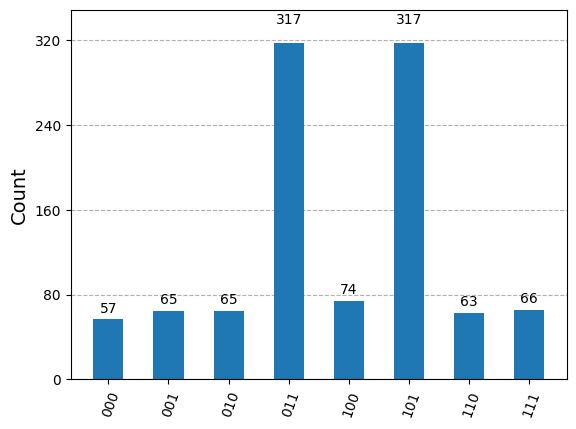

In [51]:
#Simulate your circuit!
backend = Aer.get_backend('qasm_simulator')
counts= backend.run(qc, shots=1024).result().get_counts(qc)
print(counts)
plot_histogram(counts)

## Boolean Satisfiability Problems

$\text{Any Boolean function can be expressed in Conjunctive Normal Form (CNF)}$

$$\text{e.g. }\qquad f(x_{0},x_{1},x_{2})=\left(x_{0} \texttt{ OR } x_{1} \texttt{ OR }\overline{x_{2}}\right) \texttt{ AND } \left(\overline{x_{0}} \texttt{ OR }x_{2}\right)$$

$ $

$\text{SAT Problem: Does }f(x_{0},\dots x_{n-1})=1 \text{ have a solution?}$

$ $

$\text{Cook-Levin theorem: SAT is NP-complete.}$

$\text{The (classical) Shöning algorithm for SAT runs in time }\left(4/3\right)^{n}\lt\sqrt{2^{n}}$

$\text{When combined with Grover's algorithm, it can be sped up to scale as }\sqrt{\left(4/3\right)^{n}}$

<font color=blue> Note that in this context the overline means NOT </font>

<font color=blue> i.e. $\overline{x}$ means NOT $x$ </font>

<font color=blue> e.g. if $x=0$ then $\overline{x}=1$ </font>

### Reversible Boolean Logic

$$\text{De Morgan's law }\qquad \overline{\overline{x_{1}}\texttt{ AND }\overline{x_{2}}} = x_{1}\texttt{ OR } x_{2}$$

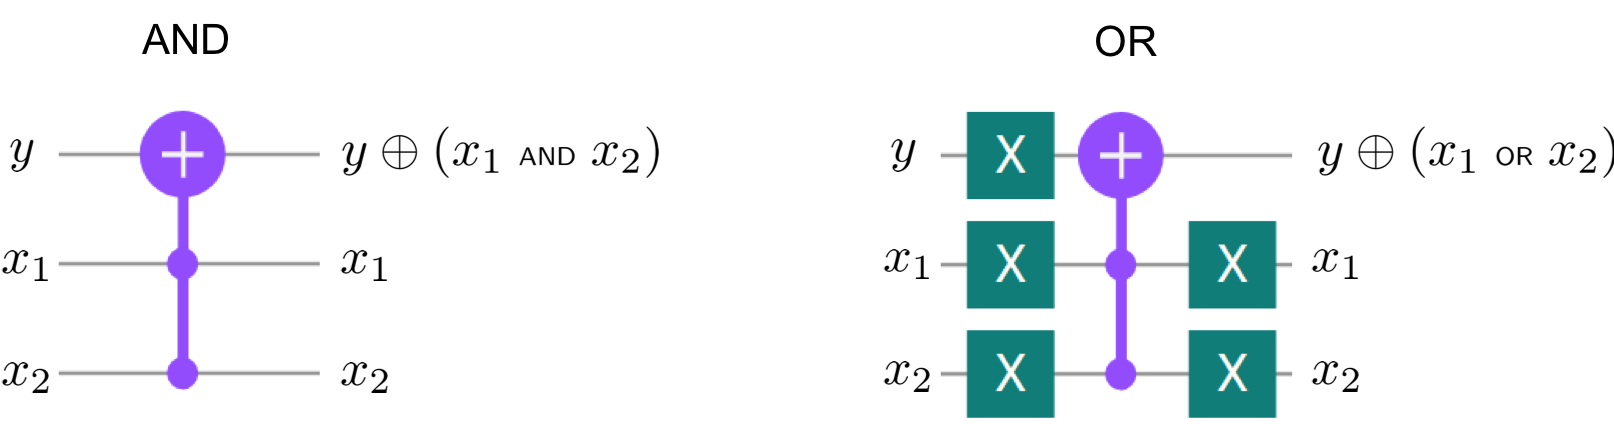

### Building Clauses

$\text{Example clause:}\quad f(x_{0},x_{1},x_{2})= x_{0} \texttt{ OR } x_{1} \texttt{ OR }\overline{x_{2}} = \left(x_{0} \texttt{ OR }x_{1}\right)\texttt{ OR }\overline{x_{2}}$

$\text{We can store the result of the first logical operation in an }\textbf{auxiliary qubit}\text{ for use in the next logical operation.}$

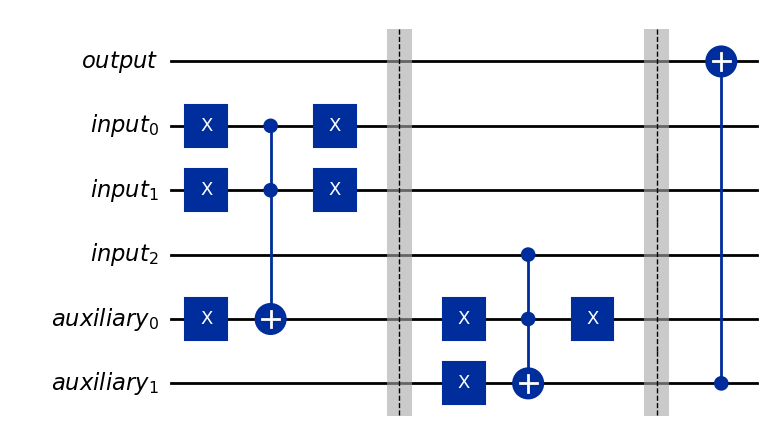

In [52]:
oq = QuantumRegister(1,'output')
iq = QuantumRegister(3,'input')
aq = QuantumRegister(2,'auxiliary')

qc = QuantumCircuit(oq,iq,aq)

#First x0 OR x1
qc.x(iq[0])
qc.x(iq[1])
qc.x(aq[0])
qc.ccx(iq[0],iq[1],aq[0])
qc.x(iq[0])
qc.x(iq[1])
qc.barrier()

#Next, the result OR NOT x2
qc.x(aq[0])
qc.x(aq[1])
qc.ccx(iq[2],aq[0],aq[1])
qc.x(aq[0])
qc.barrier()

#Finally, send the result to the output
qc.cx(aq[1],oq)

qc.draw('mpl')

$f(x_{0},x_{1},x_{2})= x_{0} \texttt{ OR } x_{1} \texttt{ OR }\overline{x_{2}} = \left(x_{0} \texttt{ OR }x_{1}\right)\texttt{ OR }\overline{x_{2}}$

### Combining Clauses

$\text{Example clause:}\quad f(x_{0},x_{1},x_{2})=\left(x_{0} \texttt{ OR } x_{1} \texttt{ OR }\overline{x_{2}}\right) \texttt{ AND } \left(\overline{x_{0}} \texttt{ OR }x_{2}\right)$

$\text{Combine clauses by ANDing their results.}$

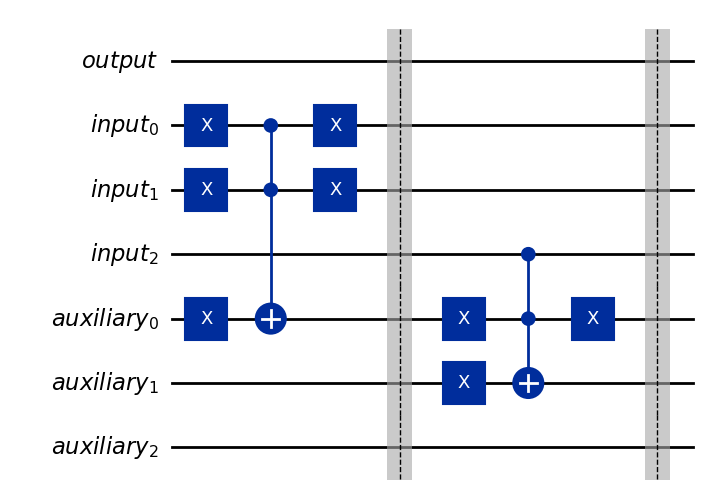

In [53]:
oq = QuantumRegister(1,'output')
iq = QuantumRegister(3,'input')
aq = QuantumRegister(3,'auxiliary')

qc = QuantumCircuit(oq,iq,aq)

#First x0 OR x1
qc.x(iq[0])
qc.x(iq[1])
qc.x(aq[0])
qc.ccx(iq[0],iq[1],aq[0])
qc.x(iq[0])
qc.x(iq[1])
qc.barrier()

#Next, the result OR NOT x2
qc.x(aq[0])
qc.x(aq[1])
qc.ccx(iq[2],aq[0],aq[1])
qc.x(aq[0])
qc.barrier()

# #Next, work on the second clause - NOT x0 OR x2
# qc.x(iq[2])
# qc.x(aq[2])
# qc.ccx(iq[0],iq[2],aq[2])
# qc.x(iq[2])
# qc.barrier()

# #Finally, perform the AND and send the result to the output
# qc.ccx(aq[2],aq[1],oq)


qc.draw('mpl')

$f(x_{0},x_{1},x_{2})=\left(x_{0} \texttt{ OR } x_{1} \texttt{ OR }\overline{x_{2}}\right) \texttt{ AND } \left(\overline{x_{0}} \texttt{ OR }x_{2}\right)$

### Reusing Qubits

$f(x_{0},x_{1},x_{2})=\left(x_{0} \texttt{ OR } x_{1} \texttt{ OR }\overline{x_{2}}\right) \texttt{ AND } \left(\overline{x_{0}} \texttt{ OR }x_{2}\right)$

$\text{Because we use reversible logical operations, we can }\textbf{uncompute}\text{ parts of the circuit to restore qubits to their earlier states}$

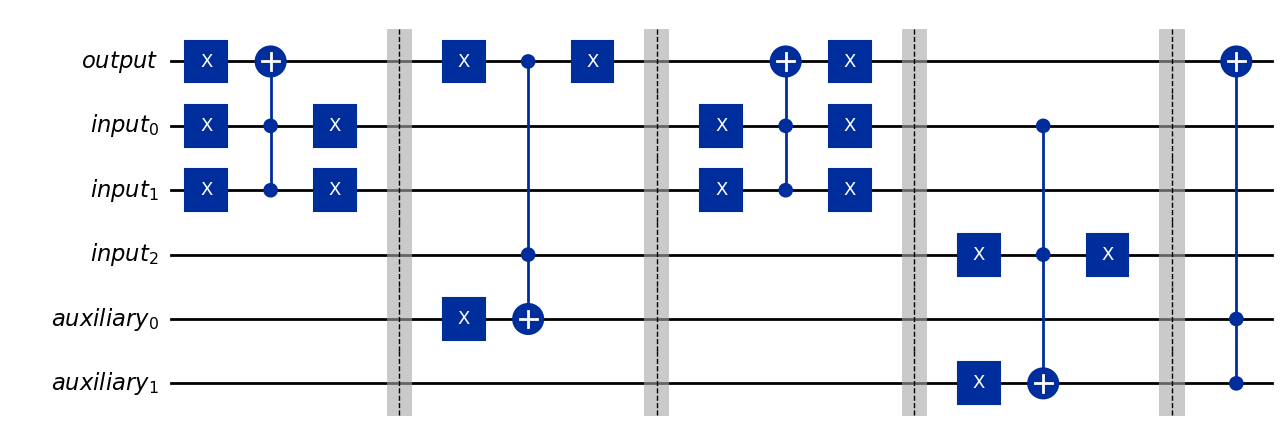

In [54]:
oq = QuantumRegister(1,'output')
iq = QuantumRegister(3,'input')
aq = QuantumRegister(2,'auxiliary')

qc = QuantumCircuit(oq,iq,aq)

#First x0 OR x1
qc.x(oq[0])
qc.x(iq[1])
qc.x(iq[0])
qc.ccx(iq[0],iq[1],oq[0])
qc.x(iq[0])
qc.x(iq[1])
qc.barrier()

#Next, the result OR NOT x2
qc.x(oq[0])
qc.x(aq[0])
qc.ccx(oq[0],iq[2],aq[0])
qc.x(oq[0])
qc.barrier()

#Then UNCOMPUTE the first OR, because the result is currently in aq[0]
qc.x(iq[1])
qc.x(iq[0])
qc.ccx(iq[0],iq[1],oq[0])
qc.x(iq[0])
qc.x(iq[1])
qc.x(oq[0])
qc.barrier()


#Next, work on the second clause
qc.x(iq[2])
qc.x(aq[1])
qc.ccx(iq[0],iq[2],aq[1])
qc.x(iq[2])
qc.barrier()

#Finally, perform the AND and send the result to the output
qc.ccx(aq[1],aq[0],oq)

qc.draw('mpl')

By reusing qubits, we only need a single auxiliary qubit per clause.

### <font color=green>Exercise 2</font>


Build a quantum circuit to implement the following Boolean function

$f(x_{0},x_{1},x_{2})= \left( x_{0}\texttt{ OR }\overline{x_{1}}\right) \texttt{ AND } \left(\overline{x_{0}} \texttt{ OR } x_{1} \texttt{ OR }\overline{x_{2}}\right)$

Try to use a minimal number of auxiliary qubits.

**You are only building the oracle.**

You need not implement Grover's algorithm for this exercise.

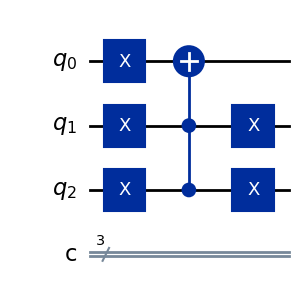

In [103]:
orGate = QuantumCircuit(3,3)
orGate.x(orGate.qubits[0:3])
orGate.ccx(2,1,0)
orGate.x(orGate.qubits[1:3])

orGate.draw('mpl')
# qubit 1 is where we stored

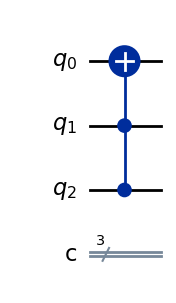

In [76]:

andGate =QuantumCircuit(3,3)
andGate.ccx(1,2,0)
andGate.draw('mpl')


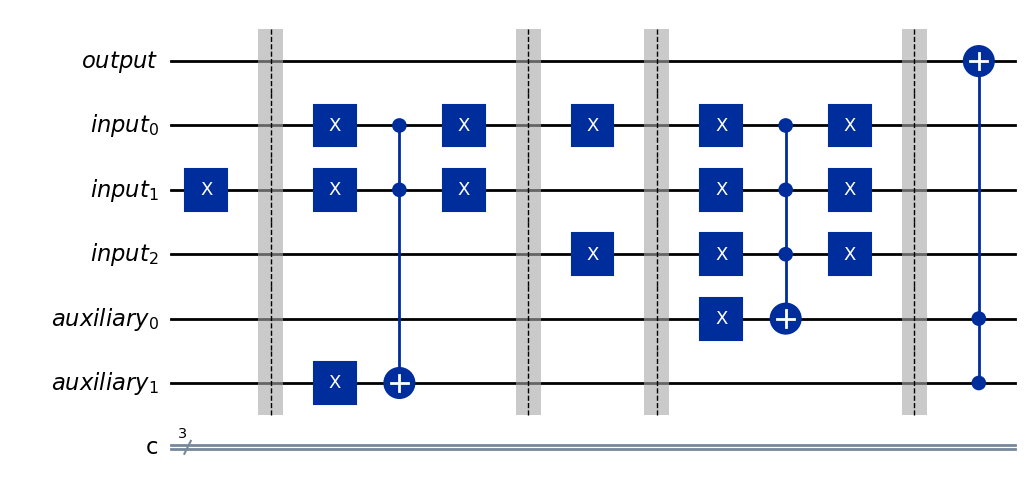

In [127]:
oq = QuantumRegister(1,'output')
iq = QuantumRegister(3,'input')
aq = QuantumRegister(2,'auxiliary')
qc = QuantumCircuit(oq,iq,aq)
qc.x(2)
qc.barrier()
qc.compose(orGate,qubits=[5,2,1],inplace=True)
qc.barrier()

qc.x(1)
qc.x(3)
qc.barrier()
qc.x(qc.qubits[1:5])
qc.mcx([1,2,3],4)
qc.x(qc.qubits[1:4])
qc.barrier()

qc.compose(andGate,qubits=[0,4,5],inplace=True)
qc.draw('mpl')


### Exclusive Sum of Products (ESOP)

We have been working with our Boolean expressions in Conjunctive Normal Form. CNF Boolean expressions are written as __AND__s of __OR__s.

In ESOP form, we write expressions as __XOR__s of __AND__s.

$$a\texttt{ OR }b=a\texttt{ XOR }b\texttt{ XOR }\left(a\texttt{ AND }b\right)$$

For easier manipulation, we use an alternative notation denoting $\texttt{OR}$ as "+", $\texttt{AND}$ as multiplication, and $\texttt{XOR}$ as "$\oplus$".
$$a+b = a \oplus b \oplus ab$$

#### Example:

$$
\begin{align}
\left(x_{1}\texttt{ OR }\overline{x_{2}}\right) \texttt{ AND }x_{3} = & \left(x_{1}+\overline{x_{2}}\right)x_{3} \\
\\
= & \left(x_{1}\oplus\overline{x_{2}}\oplus x_{1}\overline{x_{2}}\right)x_{3} \\
\\
= & x_{1}x_{3} \oplus \overline{x_{2}}x_{3} \oplus x_{1}\overline{x_{2}}x_{3}
\end{align}
$$

##### Implementing the quantum circuit for an expression in ESOP form is straightforward. (Unfortunately, converting from CNF to ESOP form is a computationally difficult problem.)

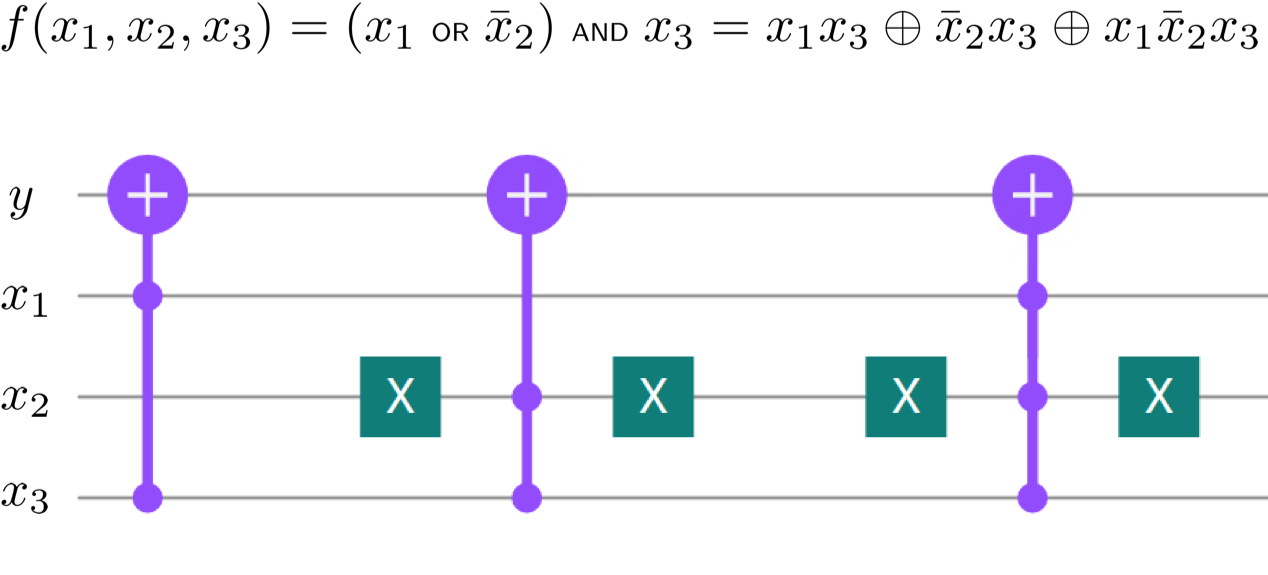

How to implement that CCCX?

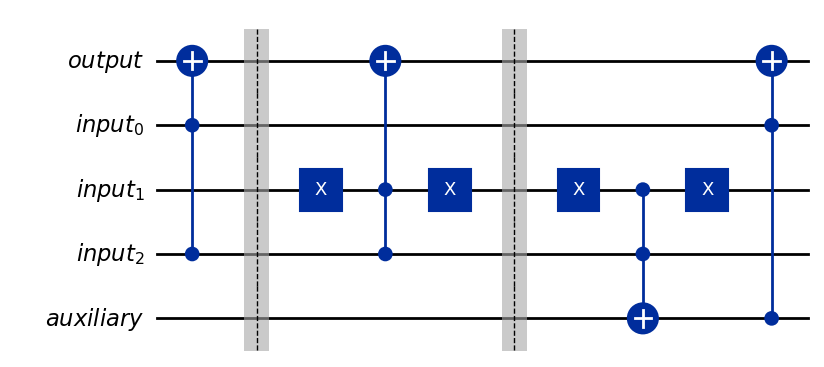

In [55]:
oq = QuantumRegister(1,'output')
iq = QuantumRegister(3,'input')
aq = QuantumRegister(1,'auxiliary')

qc = QuantumCircuit(oq,iq,aq)

#x0 AND x2  (x1 AND x3 in the diagram)
qc.ccx(iq[2],iq[0],oq)
qc.barrier()

#NOT x1 AND x2  (NOT x2 AND x3 in the diagram)
qc.x(iq[1])
qc.ccx(iq[2],iq[1],oq)
qc.x(iq[1])
qc.barrier()

#Do the CCCX in two steps
#Step1
#NOT x1 AND x2    (NOT x2 AND x3 in the diagram)
qc.x(iq[1])
qc.ccx(iq[2],iq[1],aq)
qc.x(iq[1])

#Step2
#Result AND x0    (Result AND x1 in the diagram)
qc.ccx(aq,iq[0],oq)


qc.draw('mpl')

You can manually break a multi-controlled gate into steps, or you can use pre-built multi-controlled gates (like your recursive Toffoli gates)!

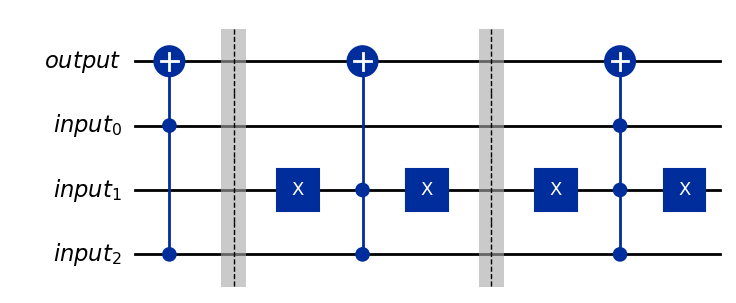

In [56]:
oq = QuantumRegister(1,'output')
iq = QuantumRegister(3,'input')

qc = QuantumCircuit(oq,iq)

#x0 AND x2  (x1 AND x3 in the diagram)
qc.ccx(iq[2],iq[0],oq)
qc.barrier()

#NOT x1 AND x2  (NOT x2 AND x3 in the diagram)
qc.x(iq[1])
qc.ccx(iq[2],iq[1],oq)
qc.x(iq[1])
qc.barrier()

#Do the CCCX in one step
#x0 AND NOT x1 AND x2     (x1 AND NOT x2 AND x3 in the diagram)
qc.x(iq[1])
qc.mcx(iq,oq)
qc.x(iq[1])


qc.draw('mpl')
#qc.decompose().draw('mpl')

In case we want to rewrite the logical expression with zero-indexing

$f\left(x_{0},x_{1},x_{2}\right) = \left(x_{0} \texttt{ OR } \overline{x_{1}}\right) \texttt{ AND } x_{2} = x_{0}x_{2} \oplus \overline{x_{1}}x_{2} \oplus x_{0}\overline{x_{1}}x_{2}$